In [1]:
import pandas as pd

In [2]:
import os
import sys
dir_path = '/'.join(os.path.realpath('.').split('/')[:-1])
print(dir_path)
sys.path.append(f'{dir_path}/sabatinilab-glm/backend')
sys.path.append(f'{dir_path}/..')
sys.path.append(f'{dir_path}/backend')
sys.path.append(f'{dir_path}/../backend')

import time
import numpy as np
import sglm
import sglm_cv
import sglm_pp
import sglm_ez
import sglm_plt as splt
import sglm_save as ssave
from lynne_pp import *
import pandas as pd
import matplotlib.pyplot as plt


/Users/josh/Documents/Harvard/GLM


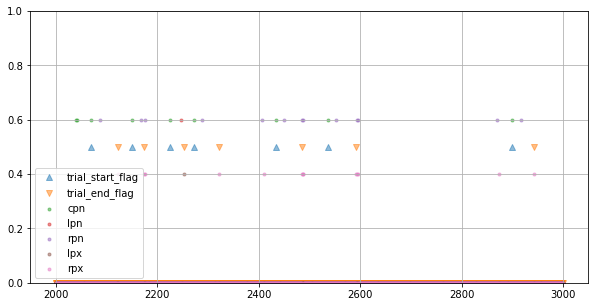

In [3]:
df = pd.read_csv('/Users/josh/Documents/Harvard/GLM/GLM_SIGNALS_WT61_10062021.txt')
df = df[[_ for _ in df.columns if 'Unnamed' not in _]]
df = rename_columns(df)
df = define_trial_starts_ends(df, trial_shift_bounds=0)

lb = 2000
ub = 3000

plt.figure(figsize=(10,5))
care = df.iloc[lb:ub]
for col in ['trial_start_flag', 'trial_end_flag', 'cpn', 'lpn', 'rpn', 'lpx', 'rpx']:
    if col == 'trial_start_flag':
        marker = '^'
        mult = 0.5
    elif col == 'trial_end_flag':
        marker = 'v'
        mult = 0.5
    else:
        marker = '.'
        if col[-1] == 'n':
            mult = 0.6
        else:
            mult = 0.4
    care_filt = care#[care[col] > 0]
    plt.scatter(care_filt.index, care_filt[col]*mult, label=col, alpha=0.5, marker=marker)
plt.ylim(0,1)
plt.grid(True, which='both')
plt.legend()

In [4]:
df_t = pd.read_csv('/Users/josh/Documents/Harvard/GLM/GLM_TABLE_WT61_10062021.txt')
df_t

,hasAllPhotometryData,photometryCenterInIndex,photometryCenterOutIndex,photometrySideInIndex,photometrySideOutIndex,photometryFirstLickIndex,choseLeft,choseRight,leftRewardProb,rightRewardProb,wasRewarded
0,0,0,0,0,0,0,1,0,0.1,0.9,0
1,0,0,0,0,0,0,1,0,0.1,0.9,0
2,0,0,0,0,0,0,1,0,0.1,0.9,0
3,0,0,0,0,0,0,1,0,0.1,0.9,0
4,0,0,0,0,0,0,1,0,0.1,0.9,0
...,...,...,...,...,...,...,...,...,...,...,...
260,1,28386,28387,28404,28444,28408,0,1,0.1,0.9,1
261,1,28544,28545,28561,28588,28564,0,1,0.1,0.9,1
262,1,28714,28715,28729,28758,28736,0,1,0.1,0.9,1
263,1,28810,28811,28828,28864,28832,0,1,0.1,0.9,1


In [5]:
# dftmp = df.copy()
# dftmp.loc[df_t['photometrySideOutIndex'].values].drop(0)

In [6]:
# idx = 1354
# dftmp.loc[idx-10:idx+10]

In [7]:
col_lst = [
    'photometryCenterInIndex',
    'photometryCenterOutIndex',
    'photometrySideInIndex',
    'photometrySideOutIndex',
    'photometryFirstLickIndex'
]

In [8]:
import glob

data_folder = '/Users/josh/Documents/Harvard/GLM'

df2 = pd.DataFrame()

# GLM_SIGNALS_WT61_10062021.txt

for fn in glob.glob(f'{data_folder}/GLM_SIGNALS_WT61_*.txt'):
    table_fn = fn.replace('GLM_SIGNALS', 'GLM_TABLE')
    print(fn, '--', table_fn)

    df_t = pd.read_csv(table_fn)

    df = pd.read_csv(fn)    
    df = df[[_ for _ in df.columns if 'Unnamed' not in _]]

    df = preprocess_lynne(df, trial_shift_bounds=0)

    for col in df_t.columns:
        if 'Index' not in col:
            continue
        print(col)
        df_t_tmp = df_t[(df_t['hasAllPhotometryData'] > 0)&(df_t[col] > 0)].copy()
        df_t_tmp[col] = df_t_tmp[col] - 1
        # display(df_t_tmp.set_index(col)[['wasRewarded']])
        # display(df.columns)

        # df[col] = df_t_tmp.set_index(col)['wasRewarded']

        num_inx_vals = df_t_tmp.groupby(col)['hasAllPhotometryData'].count()
        dupe_inx_vals = num_inx_vals[num_inx_vals > 1].index

        # if len(dupe_inx_vals) > 0:
        #     display(df_t_tmp[df_t_tmp['photometryCenterOutIndex'].isin(dupe_inx_vals)])

        single_inx_vals = num_inx_vals[num_inx_vals == 1].index

        df[col] = df_t_tmp[df_t_tmp[col].isin(single_inx_vals)].set_index(col)['wasRewarded']

        df[f'{col}_r'] = df[col]
        df[f'{col}_nr'] = (1 - df[col])

        if 'Side' in col:
            print(f'reward doesnt equal {col}')
            display(df[(df['nr'] == df['r'])&(df['nr'] == 1)])
            display(df[(df['r'] == df['r'])&(df[col] == df[col])&(df[col] == 1)])

    df['nTrial2'] = ((~df['photometryCenterInIndex'].isna())*1).cumsum()
    df['nEndTrial2'] = ((~df['photometrySideOutIndex'].isna())*1).cumsum()



    print(df2.isna().sum().sum())

    if len(df2) == 0:
        df2 = df.copy()
    else:
        df2 = df2.append(df)

    # display(df2)
    # break

/Users/josh/Documents/Harvard/GLM/GLM_SIGNALS_WT61_10152021.txt -- /Users/josh/Documents/Harvard/GLM/GLM_TABLE_WT61_10152021.txt
Percent of Data in ITI: 0.5209486722342123
photometryCenterInIndex
photometryCenterOutIndex
photometrySideInIndex
reward doesnt equal photometrySideInIndex


,Ch1,Ch2,Ch5,Ch6,GP_1,GP_2,GP_5,GP_6,SGP_1,SGP_2,...,ft_nr_spn,photometryCenterInIndex,photometryCenterInIndex_r,photometryCenterInIndex_nr,photometryCenterOutIndex,photometryCenterOutIndex_r,photometryCenterOutIndex_nr,photometrySideInIndex,photometrySideInIndex_r,photometrySideInIndex_nr


,Ch1,Ch2,Ch5,Ch6,GP_1,GP_2,GP_5,GP_6,SGP_1,SGP_2,...,ft_nr_spn,photometryCenterInIndex,photometryCenterInIndex_r,photometryCenterInIndex_nr,photometryCenterOutIndex,photometryCenterOutIndex_r,photometryCenterOutIndex_nr,photometrySideInIndex,photometrySideInIndex_r,photometrySideInIndex_nr
1202,2.707438,0.090578,2.069885,-0.623886,-2.215148,1.132251,0.727019,-0.218724,-2.215148,1.132251,...,0.0,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1.0,0.0
1346,1.850648,-0.201337,1.892693,1.668396,0.002216,0.335276,0.519662,0.559641,0.002216,0.335276,...,0.0,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1.0,0.0
1524,2.565413,-1.559312,1.777184,0.422764,-0.814681,2.364577,-1.080043,0.360160,-0.814681,2.364577,...,0.0,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1.0,0.0
1625,2.814570,0.186327,2.095783,-0.080005,-0.359426,-1.131166,0.625381,-0.604739,-0.359426,-1.131166,...,0.0,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1.0,0.0
1754,3.698313,-2.367910,2.843201,-0.149372,-0.422743,-0.018498,-0.920411,0.447691,-0.422743,-0.018498,...,0.0,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41800,2.335121,-0.671014,1.295941,-0.140277,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1.0,0.0
41883,1.190133,1.593389,0.692636,0.386482,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1.0,0.0
42074,1.540861,1.543941,0.967937,-0.032834,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1.0,0.0
42174,2.244392,-0.536127,1.502663,-0.213873,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1.0,0.0


photometrySideOutIndex
reward doesnt equal photometrySideOutIndex


,Ch1,Ch2,Ch5,Ch6,GP_1,GP_2,GP_5,GP_6,SGP_1,SGP_2,...,photometryCenterInIndex_nr,photometryCenterOutIndex,photometryCenterOutIndex_r,photometryCenterOutIndex_nr,photometrySideInIndex,photometrySideInIndex_r,photometrySideInIndex_nr,photometrySideOutIndex,photometrySideOutIndex_r,photometrySideOutIndex_nr


,Ch1,Ch2,Ch5,Ch6,GP_1,GP_2,GP_5,GP_6,SGP_1,SGP_2,...,photometryCenterInIndex_nr,photometryCenterOutIndex,photometryCenterOutIndex_r,photometryCenterOutIndex_nr,photometrySideInIndex,photometrySideInIndex_r,photometrySideInIndex_nr,photometrySideOutIndex,photometrySideOutIndex_r,photometrySideOutIndex_nr
1241,-0.305496,-0.372916,-0.538906,0.502469,-0.272448,0.115847,0.259745,0.576892,-0.272448,0.115847,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1.0,0.0
1391,-0.966553,-1.473662,-0.916871,-0.304529,-2.168256,0.058039,0.187777,1.694140,-2.168256,0.058039,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1.0,0.0
1563,1.125403,0.167957,0.941592,0.639613,-2.412390,-0.147816,0.905226,-0.302616,-2.412390,-0.147816,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1.0,0.0
1662,0.544740,1.743719,1.480347,-0.450402,-0.489170,0.956842,-0.187927,-0.074085,-0.489170,0.956842,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1.0,0.0
1789,-0.484495,1.556434,-1.236224,-0.685336,-0.890058,0.074960,-0.357623,0.424553,-0.890058,0.074960,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41841,1.269824,-0.520394,0.335098,-1.770162,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1.0,0.0
41937,-1.869221,-1.084935,-2.267933,-0.942506,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1.0,0.0
42113,-0.857991,0.116717,-1.462729,-0.255824,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1.0,0.0
42206,-1.254567,2.649446,-1.027268,-0.925426,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1.0,0.0


photometryFirstLickIndex
0.0
/Users/josh/Documents/Harvard/GLM/GLM_SIGNALS_WT61_10042021.txt -- /Users/josh/Documents/Harvard/GLM/GLM_TABLE_WT61_10042021.txt
Percent of Data in ITI: 0.5350604796971579
photometryCenterInIndex
photometryCenterOutIndex
photometrySideInIndex
reward doesnt equal photometrySideInIndex


,Ch1,Ch2,Ch5,Ch6,GP_1,GP_2,GP_5,GP_6,SGP_1,SGP_2,...,ft_nr_spn,photometryCenterInIndex,photometryCenterInIndex_r,photometryCenterInIndex_nr,photometryCenterOutIndex,photometryCenterOutIndex_r,photometryCenterOutIndex_nr,photometrySideInIndex,photometrySideInIndex_r,photometrySideInIndex_nr


,Ch1,Ch2,Ch5,Ch6,GP_1,GP_2,GP_5,GP_6,SGP_1,SGP_2,...,ft_nr_spn,photometryCenterInIndex,photometryCenterInIndex_r,photometryCenterInIndex_nr,photometryCenterOutIndex,photometryCenterOutIndex_r,photometryCenterOutIndex_nr,photometrySideInIndex,photometrySideInIndex_r,photometrySideInIndex_nr
1203,0.336256,-0.363530,0.071817,-0.171821,0.991556,-1.425949,0.303008,0.520328,0.991556,-1.425949,...,0.0,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1.0,0.0
1371,1.942007,-0.468159,0.713225,-0.727935,0.784470,0.242621,0.605631,-0.933841,0.784470,0.242621,...,0.0,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1.0,0.0
1452,1.214274,-0.550391,0.869013,-0.409910,-0.443005,-0.360992,1.241996,-1.945803,-0.443005,-0.360992,...,0.0,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1.0,0.0
2567,0.832566,0.742424,1.627778,0.733107,-0.002156,0.330444,1.220990,-0.437097,-0.002156,0.330444,...,0.0,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1.0,0.0
2668,-0.423099,0.525278,-0.428706,0.635290,-0.811898,0.862521,0.152104,0.249312,-0.811898,0.862521,...,0.0,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
33021,1.618112,-0.862499,0.131838,-0.445058,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1.0,0.0
33143,1.130851,-0.647112,0.203781,-0.698994,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1.0,0.0
33257,0.905241,-0.063070,0.003108,-0.109285,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1.0,0.0
33324,0.644219,1.431556,-0.614367,1.108553,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1.0,0.0


photometrySideOutIndex
reward doesnt equal photometrySideOutIndex


,Ch1,Ch2,Ch5,Ch6,GP_1,GP_2,GP_5,GP_6,SGP_1,SGP_2,...,photometryCenterInIndex_nr,photometryCenterOutIndex,photometryCenterOutIndex_r,photometryCenterOutIndex_nr,photometrySideInIndex,photometrySideInIndex_r,photometrySideInIndex_nr,photometrySideOutIndex,photometrySideOutIndex_r,photometrySideOutIndex_nr


,Ch1,Ch2,Ch5,Ch6,GP_1,GP_2,GP_5,GP_6,SGP_1,SGP_2,...,photometryCenterInIndex_nr,photometryCenterOutIndex,photometryCenterOutIndex_r,photometryCenterOutIndex_nr,photometrySideInIndex,photometrySideInIndex_r,photometrySideInIndex_nr,photometrySideOutIndex,photometrySideOutIndex_r,photometrySideOutIndex_nr
1245,-0.939301,-0.211040,-0.438857,-0.546863,0.036343,-0.516769,1.112406,-0.176943,0.036343,-0.516769,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1.0,0.0
1408,-1.303085,0.155591,-0.742169,0.014797,0.851948,-0.474108,-0.236300,-1.013755,0.851948,-0.474108,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1.0,0.0
1496,-1.596247,0.641386,-1.965753,0.255878,-0.938390,-0.677788,-0.932295,-1.251148,-0.938390,-0.677788,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1.0,0.0
2604,-1.270408,0.939711,-1.117557,0.822623,0.834621,-1.108663,1.672740,0.159931,0.834621,-1.108663,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1.0,0.0
2708,-1.680378,-0.322020,-1.152959,0.549837,0.022422,1.185472,1.032286,0.816767,0.022422,1.185472,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
33049,0.087966,-1.443925,-0.371999,-0.364915,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1.0,0.0
33177,-0.855336,0.235718,-0.355523,0.393169,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1.0,0.0
33291,-0.427462,0.692422,-1.462003,0.122931,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1.0,0.0
33387,-1.539220,0.574861,0.265658,1.108127,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1.0,0.0


photometryFirstLickIndex
634488
/Users/josh/Documents/Harvard/GLM/GLM_SIGNALS_WT61_10062021.txt -- /Users/josh/Documents/Harvard/GLM/GLM_TABLE_WT61_10062021.txt
Percent of Data in ITI: 0.5380593677983009
photometryCenterInIndex
photometryCenterOutIndex
photometrySideInIndex
reward doesnt equal photometrySideInIndex


,Ch1,Ch2,Ch5,Ch6,GP_1,GP_2,GP_5,GP_6,SGP_1,SGP_2,...,ft_nr_spn,photometryCenterInIndex,photometryCenterInIndex_r,photometryCenterInIndex_nr,photometryCenterOutIndex,photometryCenterOutIndex_r,photometryCenterOutIndex_nr,photometrySideInIndex,photometrySideInIndex_r,photometrySideInIndex_nr


,Ch1,Ch2,Ch5,Ch6,GP_1,GP_2,GP_5,GP_6,SGP_1,SGP_2,...,ft_nr_spn,photometryCenterInIndex,photometryCenterInIndex_r,photometryCenterInIndex_nr,photometryCenterOutIndex,photometryCenterOutIndex_r,photometryCenterOutIndex_nr,photometrySideInIndex,photometrySideInIndex_r,photometrySideInIndex_nr
1181,-0.273506,1.508508,-0.490919,0.871145,-0.721519,0.274819,-0.783449,0.323408,-0.721519,0.274819,...,0.0,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1.0,0.0
1309,0.407346,0.359547,-0.872307,0.773805,0.927987,-1.323426,-0.442906,-2.447461,0.927987,-1.323426,...,0.0,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1.0,0.0
1432,-0.931182,0.100518,-1.150057,-0.119677,0.390144,-0.692107,1.332674,-0.209122,0.390144,-0.692107,...,0.0,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1.0,0.0
1695,0.336425,0.099666,0.225005,0.575058,0.760108,0.132000,0.477949,-1.675929,0.760108,0.132000,...,0.0,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1.0,0.0
1780,-0.253458,0.172867,-1.177227,-0.356489,0.508025,0.361655,-0.223125,1.327977,0.508025,0.361655,...,0.0,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28403,2.274150,-0.212680,1.257708,0.245925,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1.0,0.0
28560,0.624177,-0.249908,-0.254334,0.139929,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1.0,0.0
28728,1.728798,1.135859,0.460129,-0.528016,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1.0,0.0
28827,0.619132,0.295518,-0.021005,-0.628156,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1.0,0.0


photometrySideOutIndex
reward doesnt equal photometrySideOutIndex


,Ch1,Ch2,Ch5,Ch6,GP_1,GP_2,GP_5,GP_6,SGP_1,SGP_2,...,photometryCenterInIndex_nr,photometryCenterOutIndex,photometryCenterOutIndex_r,photometryCenterOutIndex_nr,photometrySideInIndex,photometrySideInIndex_r,photometrySideInIndex_nr,photometrySideOutIndex,photometrySideOutIndex_r,photometrySideOutIndex_nr


,Ch1,Ch2,Ch5,Ch6,GP_1,GP_2,GP_5,GP_6,SGP_1,SGP_2,...,photometryCenterInIndex_nr,photometryCenterOutIndex,photometryCenterOutIndex_r,photometryCenterOutIndex_nr,photometrySideInIndex,photometrySideInIndex_r,photometrySideInIndex_nr,photometrySideOutIndex,photometrySideOutIndex_r,photometrySideOutIndex_nr
1223,-1.407108,-1.020830,-1.264660,0.039480,1.078082,-0.728802,0.349277,1.607476,1.078082,-0.728802,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1.0,0.0
1353,-1.545299,-0.789316,-0.760881,-0.173552,0.775700,0.727921,1.144262,2.675061,0.775700,0.727921,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1.0,0.0
1471,-1.520356,-1.185046,-1.063585,-0.760116,0.797781,-0.404370,0.811649,0.214650,0.797781,-0.404370,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1.0,0.0
1724,-1.064572,0.457028,-0.354341,0.310321,-0.939239,0.335869,1.478936,1.238692,-0.939239,0.335869,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1.0,0.0
1817,-1.581764,1.079877,-1.043073,0.727819,0.537123,1.821194,0.667736,-1.136201,0.537123,1.821194,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28443,-0.769825,0.443838,0.060243,0.144966,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1.0,0.0
28587,0.323274,0.144718,0.737512,0.360136,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1.0,0.0
28757,-0.734566,-0.136251,-0.440527,0.306526,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1.0,0.0
28863,-0.507639,0.343671,-0.191772,1.236918,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1.0,0.0


photometryFirstLickIndex
1138127
/Users/josh/Documents/Harvard/GLM/GLM_SIGNALS_WT61_10132021.txt -- /Users/josh/Documents/Harvard/GLM/GLM_TABLE_WT61_10132021.txt
Percent of Data in ITI: 0.532343745256959
photometryCenterInIndex
photometryCenterOutIndex
photometrySideInIndex
reward doesnt equal photometrySideInIndex


,Ch1,Ch2,Ch5,Ch6,GP_1,GP_2,GP_5,GP_6,SGP_1,SGP_2,...,ft_nr_spn,photometryCenterInIndex,photometryCenterInIndex_r,photometryCenterInIndex_nr,photometryCenterOutIndex,photometryCenterOutIndex_r,photometryCenterOutIndex_nr,photometrySideInIndex,photometrySideInIndex_r,photometrySideInIndex_nr


,Ch1,Ch2,Ch5,Ch6,GP_1,GP_2,GP_5,GP_6,SGP_1,SGP_2,...,ft_nr_spn,photometryCenterInIndex,photometryCenterInIndex_r,photometryCenterInIndex_nr,photometryCenterOutIndex,photometryCenterOutIndex_r,photometryCenterOutIndex_nr,photometrySideInIndex,photometrySideInIndex_r,photometrySideInIndex_nr
1753,3.093915,-2.017622,2.712873,-1.799075,0.675316,0.668921,0.955043,-1.018514,0.675316,0.668921,...,0.0,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1.0,0.0
1915,2.162438,-0.572709,1.700389,-0.938639,-0.375697,-0.388765,-1.604499,0.506838,-0.375697,-0.388765,...,0.0,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1.0,0.0
2098,1.838857,-0.452389,2.106227,0.166049,0.962233,0.626033,0.197624,0.446638,0.962233,0.626033,...,0.0,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1.0,0.0
2174,0.902726,-0.034465,-0.208293,-1.115184,0.791154,-0.841351,-0.831065,-0.076534,0.791154,-0.841351,...,0.0,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1.0,0.0
2358,2.173068,-0.569356,2.681653,0.029278,-1.641077,-0.390122,-0.424506,1.042483,-1.641077,-0.390122,...,0.0,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32242,1.627975,-1.203117,0.414087,-0.283866,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1.0,0.0
32337,0.349995,1.854781,-0.130278,2.063261,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1.0,0.0
32413,1.071582,0.865721,0.604558,0.238427,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1.0,0.0
32492,1.616189,-0.722737,0.762423,-1.511257,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1.0,0.0


photometrySideOutIndex
reward doesnt equal photometrySideOutIndex


,Ch1,Ch2,Ch5,Ch6,GP_1,GP_2,GP_5,GP_6,SGP_1,SGP_2,...,photometryCenterInIndex_nr,photometryCenterOutIndex,photometryCenterOutIndex_r,photometryCenterOutIndex_nr,photometrySideInIndex,photometrySideInIndex_r,photometrySideInIndex_nr,photometrySideOutIndex,photometrySideOutIndex_r,photometrySideOutIndex_nr


,Ch1,Ch2,Ch5,Ch6,GP_1,GP_2,GP_5,GP_6,SGP_1,SGP_2,...,photometryCenterInIndex_nr,photometryCenterOutIndex,photometryCenterOutIndex_r,photometryCenterOutIndex_nr,photometrySideInIndex,photometrySideInIndex_r,photometrySideInIndex_nr,photometrySideOutIndex,photometrySideOutIndex_r,photometrySideOutIndex_nr
1778,-2.003733,-0.611184,-1.218698,-0.166062,-1.234649,-0.329695,-1.917403,0.261133,-1.234649,-0.329695,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1.0,0.0
1948,-1.843812,0.518121,-1.014286,-0.160168,0.204561,-1.970564,1.223091,-0.205240,0.204561,-1.970564,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1.0,0.0
2127,-1.868610,0.689285,-1.369589,0.544744,1.832790,0.094186,-3.041802,1.182541,1.832790,0.094186,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1.0,0.0
2221,-1.608488,-0.817209,-1.572497,-0.063090,-1.766240,0.631113,1.151045,-0.536656,-1.766240,0.631113,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1.0,0.0
2390,-2.108044,0.042348,-1.248712,-0.714370,0.068852,0.043377,-0.960555,-1.228969,0.068852,0.043377,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32279,-0.765928,1.582139,-1.057807,-1.509988,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1.0,0.0
32372,-1.212432,1.398341,-0.866714,-0.849065,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1.0,0.0
32448,-1.504346,-0.246352,-1.087701,0.213978,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1.0,0.0
32530,0.228077,0.279593,-0.054977,-1.100547,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1.0,0.0


photometryFirstLickIndex
1570886
/Users/josh/Documents/Harvard/GLM/GLM_SIGNALS_WT61_10082021.txt -- /Users/josh/Documents/Harvard/GLM/GLM_TABLE_WT61_10082021.txt
Percent of Data in ITI: 0.49568996740311483
photometryCenterInIndex
photometryCenterOutIndex
photometrySideInIndex
reward doesnt equal photometrySideInIndex


,Ch1,Ch2,Ch5,Ch6,GP_1,GP_2,GP_5,GP_6,SGP_1,SGP_2,...,ft_nr_spn,photometryCenterInIndex,photometryCenterInIndex_r,photometryCenterInIndex_nr,photometryCenterOutIndex,photometryCenterOutIndex_r,photometryCenterOutIndex_nr,photometrySideInIndex,photometrySideInIndex_r,photometrySideInIndex_nr


,Ch1,Ch2,Ch5,Ch6,GP_1,GP_2,GP_5,GP_6,SGP_1,SGP_2,...,ft_nr_spn,photometryCenterInIndex,photometryCenterInIndex_r,photometryCenterInIndex_nr,photometryCenterOutIndex,photometryCenterOutIndex_r,photometryCenterOutIndex_nr,photometrySideInIndex,photometrySideInIndex_r,photometrySideInIndex_nr
1991,2.186798,-0.577591,2.480430,0.142582,-0.017358,-0.466600,-0.766196,-0.778295,-0.017358,-0.466600,...,0.0,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1.0,0.0
2112,0.674503,-0.234924,-0.051491,-0.615507,1.104793,-1.113265,0.939793,0.408904,1.104793,-1.113265,...,0.0,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1.0,0.0
2216,1.086405,-0.362778,0.719343,-2.048908,1.548839,-1.493658,-0.425719,1.962373,1.548839,-1.493658,...,0.0,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1.0,0.0
2335,1.403818,-0.238128,0.634701,-0.475776,0.680250,1.509344,-0.061025,-0.701115,0.680250,1.509344,...,0.0,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1.0,0.0
2453,2.060765,-1.877330,1.973950,-0.587761,1.248824,1.623047,0.622422,-0.639625,1.248824,1.623047,...,0.0,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26984,1.244891,-1.154843,0.803318,-0.957989,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1.0,0.0
27080,1.504287,1.355410,0.494972,-0.117617,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1.0,0.0
27177,1.228751,-1.153436,0.921344,0.014734,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1.0,0.0
27268,0.989864,0.657686,-0.860285,-0.179391,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1.0,0.0


photometrySideOutIndex
reward doesnt equal photometrySideOutIndex


,Ch1,Ch2,Ch5,Ch6,GP_1,GP_2,GP_5,GP_6,SGP_1,SGP_2,...,photometryCenterInIndex_nr,photometryCenterOutIndex,photometryCenterOutIndex_r,photometryCenterOutIndex_nr,photometrySideInIndex,photometrySideInIndex_r,photometrySideInIndex_nr,photometrySideOutIndex,photometrySideOutIndex_r,photometrySideOutIndex_nr


,Ch1,Ch2,Ch5,Ch6,GP_1,GP_2,GP_5,GP_6,SGP_1,SGP_2,...,photometryCenterInIndex_nr,photometryCenterOutIndex,photometryCenterOutIndex_r,photometryCenterOutIndex_nr,photometrySideInIndex,photometrySideInIndex_r,photometrySideInIndex_nr,photometrySideOutIndex,photometrySideOutIndex_r,photometrySideOutIndex_nr
2020,-0.978372,-0.184776,-1.527115,-0.468195,-0.986441,0.233935,0.596884,-0.718468,-0.986441,0.233935,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1.0,0.0
2146,0.562131,0.270921,-0.034377,-0.071268,-0.416078,1.000673,-0.025661,1.063252,-0.416078,1.000673,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1.0,0.0
2263,-0.206404,0.358201,0.026614,-1.519880,-0.295748,1.333360,0.919800,-0.626768,-0.295748,1.333360,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1.0,0.0
2374,-0.266801,0.538798,-0.343227,-1.011071,-0.464673,-1.390078,-0.238004,-2.999030,-0.464673,-1.390078,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1.0,0.0
2489,-0.750796,-1.841987,-0.939788,-0.904109,0.603548,-1.750584,-1.929154,-0.592721,0.603548,-1.750584,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27029,-0.665439,0.837977,-0.820137,0.154452,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1.0,0.0
27127,-0.349699,0.141718,-0.141129,0.347149,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1.0,0.0
27232,-0.852873,-0.191114,-1.277240,0.967426,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1.0,0.0
27325,0.150466,-0.536029,-0.317357,-0.903411,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1.0,0.0


photometryFirstLickIndex
2060958
/Users/josh/Documents/Harvard/GLM/GLM_SIGNALS_WT61_10182021.txt -- /Users/josh/Documents/Harvard/GLM/GLM_TABLE_WT61_10182021.txt
Percent of Data in ITI: 0.5969218999617487
photometryCenterInIndex
photometryCenterOutIndex
photometrySideInIndex
reward doesnt equal photometrySideInIndex


,Ch1,Ch2,Ch5,Ch6,GP_1,GP_2,GP_5,GP_6,SGP_1,SGP_2,...,ft_nr_spn,photometryCenterInIndex,photometryCenterInIndex_r,photometryCenterInIndex_nr,photometryCenterOutIndex,photometryCenterOutIndex_r,photometryCenterOutIndex_nr,photometrySideInIndex,photometrySideInIndex_r,photometrySideInIndex_nr


,Ch1,Ch2,Ch5,Ch6,GP_1,GP_2,GP_5,GP_6,SGP_1,SGP_2,...,ft_nr_spn,photometryCenterInIndex,photometryCenterInIndex_r,photometryCenterInIndex_nr,photometryCenterOutIndex,photometryCenterOutIndex_r,photometryCenterOutIndex_nr,photometrySideInIndex,photometrySideInIndex_r,photometrySideInIndex_nr
2664,-0.067565,1.080659,-0.318336,1.279549,0.086801,-1.009492,0.920769,-0.718838,0.086801,-1.009492,...,0.0,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1.0,0.0
3268,1.108690,0.180615,1.212633,0.098217,0.864093,-0.869229,1.355246,0.142062,0.864093,-0.869229,...,0.0,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1.0,0.0
3480,1.022801,-0.063754,1.651215,1.162500,1.129565,1.435860,0.544483,0.945229,1.129565,1.435860,...,0.0,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1.0,0.0
3626,-0.027586,-0.525575,0.911744,1.605432,0.216508,0.294405,-0.482413,-0.724430,0.216508,0.294405,...,0.0,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1.0,0.0
3928,1.289390,0.521277,0.873688,-1.274695,1.694898,-1.307933,0.160324,-0.482421,1.694898,-1.307933,...,0.0,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
42399,1.300749,-0.071974,0.828891,-0.011389,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1.0,0.0
42644,1.477063,-0.114649,1.279156,-0.077481,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1.0,0.0
42861,2.353029,-0.045647,0.824498,-1.161806,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1.0,0.0
43035,2.518173,-0.455233,0.688141,-0.831257,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1.0,0.0


photometrySideOutIndex
reward doesnt equal photometrySideOutIndex


,Ch1,Ch2,Ch5,Ch6,GP_1,GP_2,GP_5,GP_6,SGP_1,SGP_2,...,photometryCenterInIndex_nr,photometryCenterOutIndex,photometryCenterOutIndex_r,photometryCenterOutIndex_nr,photometrySideInIndex,photometrySideInIndex_r,photometrySideInIndex_nr,photometrySideOutIndex,photometrySideOutIndex_r,photometrySideOutIndex_nr


,Ch1,Ch2,Ch5,Ch6,GP_1,GP_2,GP_5,GP_6,SGP_1,SGP_2,...,photometryCenterInIndex_nr,photometryCenterOutIndex,photometryCenterOutIndex_r,photometryCenterOutIndex_nr,photometrySideInIndex,photometrySideInIndex_r,photometrySideInIndex_nr,photometrySideOutIndex,photometrySideOutIndex_r,photometrySideOutIndex_nr
2695,-1.670957,0.955942,-0.935255,-0.241417,1.405682,-1.005573,-0.310284,-2.821007,1.405682,-1.005573,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1.0,0.0
3305,-1.909234,0.938914,-1.102374,-1.039699,0.740795,-0.650044,2.874044,-0.581273,0.740795,-0.650044,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1.0,0.0
3513,-0.845920,-0.479409,-0.068477,1.450767,0.064526,-1.162589,-1.567540,0.078147,0.064526,-1.162589,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1.0,0.0
3663,1.442811,0.547980,1.671804,-1.141192,1.244880,0.429577,-0.344804,0.608031,1.244880,0.429577,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1.0,0.0
3952,-1.770051,0.817475,-1.287627,-1.204809,-1.031477,2.305748,-0.837316,-0.339555,-1.031477,2.305748,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
42432,-1.253128,-0.857821,-0.534087,-1.342152,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1.0,0.0
42680,-0.859518,0.511707,-0.212699,1.827444,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1.0,0.0
42899,-0.047611,0.215159,-0.589278,-0.518424,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1.0,0.0
43086,-0.588671,-0.870798,0.032516,0.313706,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1.0,0.0


photometryFirstLickIndex
2471932
/Users/josh/Documents/Harvard/GLM/GLM_SIGNALS_WT61_10112021.txt -- /Users/josh/Documents/Harvard/GLM/GLM_TABLE_WT61_10112021.txt
Percent of Data in ITI: 0.479428370748575
photometryCenterInIndex
photometryCenterOutIndex
photometrySideInIndex
reward doesnt equal photometrySideInIndex


,Ch1,Ch2,Ch5,Ch6,GP_1,GP_2,GP_5,GP_6,SGP_1,SGP_2,...,ft_nr_spn,photometryCenterInIndex,photometryCenterInIndex_r,photometryCenterInIndex_nr,photometryCenterOutIndex,photometryCenterOutIndex_r,photometryCenterOutIndex_nr,photometrySideInIndex,photometrySideInIndex_r,photometrySideInIndex_nr


,Ch1,Ch2,Ch5,Ch6,GP_1,GP_2,GP_5,GP_6,SGP_1,SGP_2,...,ft_nr_spn,photometryCenterInIndex,photometryCenterInIndex_r,photometryCenterInIndex_nr,photometryCenterOutIndex,photometryCenterOutIndex_r,photometryCenterOutIndex_nr,photometrySideInIndex,photometrySideInIndex_r,photometrySideInIndex_nr
1234,0.303638,0.885938,-0.410092,0.551294,0.426223,-1.004398,1.067737,1.639595,0.426223,-1.004398,...,0.0,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1.0,0.0
1438,1.269664,-0.373193,-0.700056,0.432369,-0.108584,-1.537465,0.325520,-0.061794,-0.108584,-1.537465,...,0.0,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1.0,0.0
1674,1.689016,-0.762806,0.321898,-0.285642,2.262924,-0.410607,2.114392,0.016819,2.262924,-0.410607,...,0.0,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1.0,0.0
2191,1.056129,-1.419744,0.379435,-1.414010,-0.439353,-0.135729,0.445515,0.169960,-0.439353,-0.135729,...,0.0,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1.0,0.0
2317,1.395269,-1.127962,0.004121,-0.993264,-0.718306,-0.218257,0.082850,0.797484,-0.718306,-0.218257,...,0.0,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
36243,1.406603,-0.217059,0.881927,-0.924635,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1.0,0.0
36332,0.943472,-0.619707,0.404561,0.072228,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1.0,0.0
36430,1.746469,-0.611714,0.312048,-0.862813,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1.0,0.0
36519,0.806886,-0.545045,0.377555,-2.101615,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1.0,0.0


photometrySideOutIndex
reward doesnt equal photometrySideOutIndex


,Ch1,Ch2,Ch5,Ch6,GP_1,GP_2,GP_5,GP_6,SGP_1,SGP_2,...,photometryCenterInIndex_nr,photometryCenterOutIndex,photometryCenterOutIndex_r,photometryCenterOutIndex_nr,photometrySideInIndex,photometrySideInIndex_r,photometrySideInIndex_nr,photometrySideOutIndex,photometrySideOutIndex_r,photometrySideOutIndex_nr


,Ch1,Ch2,Ch5,Ch6,GP_1,GP_2,GP_5,GP_6,SGP_1,SGP_2,...,photometryCenterInIndex_nr,photometryCenterOutIndex,photometryCenterOutIndex_r,photometryCenterOutIndex_nr,photometrySideInIndex,photometrySideInIndex_r,photometrySideInIndex_nr,photometrySideOutIndex,photometrySideOutIndex_r,photometrySideOutIndex_nr
1279,-1.452343,-0.223768,-1.605772,-0.008199,-1.132102,-1.530505,-1.766653,0.870968,-1.132102,-1.530505,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1.0,0.0
1471,-1.381424,-0.551767,-0.084257,-0.857947,-1.645182,1.455578,0.317411,0.209186,-1.645182,1.455578,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1.0,0.0
1710,-0.903660,-0.174704,-0.173527,-0.702062,0.128780,1.645402,-0.851106,1.161602,0.128780,1.645402,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1.0,0.0
2216,-1.093008,-0.799980,-0.673127,-0.026216,0.402733,0.074179,-2.104051,0.488342,0.402733,0.074179,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1.0,0.0
2348,-0.494818,0.195000,0.022201,-0.525557,-0.341307,-1.312376,-1.338181,1.647399,-0.341307,-1.312376,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
36286,0.037943,-0.709291,-0.128403,-0.023392,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1.0,0.0
36384,-1.593189,0.715243,-1.256076,-1.234712,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1.0,0.0
36474,-0.205997,0.678711,-0.001031,-0.036595,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1.0,0.0
36566,-2.147635,0.341006,-1.697392,-0.502893,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1.0,0.0


photometryFirstLickIndex
3134487


In [9]:
# df2.iloc[1200:1245][['ft_r_spn', 'ft_nr_spn', 'nn', 'spn', 'spx', 'cpn', 'cpx', 'nTrial', 'nTrial2', 'photometryCenterInIndex']]

In [10]:
df_examine = df2[df2['photometrySideInIndex'].isna()]
df_examine = df_examine[(df_examine['ft_r_spn'] + df_examine['ft_nr_spn'] > 0)&(df_examine['nTrial'] > 0)&(df_examine['nTrial2'] > 0)&(df_examine['nTrial'] > 0)]
# with pd.option_context('max_rows', 3000):
#     display(df_examine[['ft_r_spn', 'ft_nr_spn', 'photometrySideInIndex']])

In [11]:
# glob.glob(f'{data_folder}/GLM_SIGNALS_WT61_*.txt')

In [12]:
df2

,Ch1,Ch2,Ch5,Ch6,GP_1,GP_2,GP_5,GP_6,SGP_1,SGP_2,...,photometrySideInIndex_r,photometrySideInIndex_nr,photometrySideOutIndex,photometrySideOutIndex_r,photometrySideOutIndex_nr,photometryFirstLickIndex,photometryFirstLickIndex_r,photometryFirstLickIndex_nr,nTrial2,nEndTrial2
0,0.555517,-0.207614,0.720531,-0.801691,0.452445,-1.159573,-0.603638,0.526995,0.452445,-1.159573,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0
1,0.821058,-1.212011,0.128694,0.700425,0.479802,0.440579,-1.458203,0.118326,0.479802,0.440579,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0
2,0.895495,-1.309689,0.399287,-0.639261,0.427776,0.009070,-0.136884,0.645182,0.427776,0.009070,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0
3,0.369373,0.235882,-0.657023,1.163822,1.076511,-2.299252,0.615730,1.835773,1.076511,-2.299252,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0
4,0.633833,0.080268,-0.220334,2.294948,2.274924,-1.121843,0.704893,0.508825,2.274924,-1.121843,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
37012,2.562576,-1.677753,1.878167,0.133261,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,360,360
37013,4.246441,-0.236823,4.886373,-0.874492,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,360,360
37014,4.408608,-0.663953,4.798602,-0.210249,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,360,360
37015,2.364343,0.720721,2.718583,1.764168,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,360,360


In [13]:
# import glob
# from collections import defaultdict

# fn = glob.glob(f'{data_folder}/GLM_SIGNALS_WT61_10152021.txt')[0]
# table_fn = fn.replace('GLM_SIGNALS', 'GLM_TABLE')
# print(fn, '--', table_fn)

# df_t = pd.read_csv(table_fn)

# df = pd.read_csv(fn)
# df = df[[_ for _ in df.columns if 'Unnamed' not in _]]


# for col in df_t.columns:
#     if 'Index' not in col:
#         continue
#     print(col)
#     df_t_tmp = df_t[(df_t['hasAllPhotometryData'] > 0)&(df_t[col] > 0)].copy()
#     df_t_tmp[col] = df_t_tmp[col] - 1
#     # display(df_t_tmp.set_index(col)[['wasRewarded']])
#     # display(df.columns)

#     # df[col] = df_t_tmp.set_index(col)['wasRewarded']

#     num_inx_vals = df_t_tmp.groupby(col)['hasAllPhotometryData'].count()
#     dupe_inx_vals = num_inx_vals[num_inx_vals > 1].index
#     display(df_t_tmp[df_t_tmp['photometryCenterOutIndex'].isin(dupe_inx_vals)])

#     single_inx_vals = num_inx_vals[num_inx_vals == 1].index

#     df[col] = df_t_tmp[df_t_tmp[col].isin(single_inx_vals)].set_index(col)['wasRewarded']

# df['nTrial'] = ((~df['photometryCenterInIndex'].isna())*1).cumsum()
# df['nEndTrial'] = ((~df['photometrySideOutIndex'].isna())*1).cumsum()


In [14]:
# for col_val in col_lst:
#     # new_name = col_val.replace('Index', '')
#     # df2[f'{new_name}_r'] = df2[new_name]*df2['combor']
#     # df2[f'{new_name}_nr'] = df2[new_name]*(1-df2['combor'])

#     # df2[f'{new_name}_r'] = df2[new_name]*df2['reward']
#     # df2[f'{new_name}_nr'] = df2[new_name]*(1-df2['reward'])

#     # df2[f'{new_name}_r'] = df2[new_name]*df2['wasRewarded']
#     # df2[f'{new_name}_nr'] = df2[new_name]*(1-df2['wasRewarded'])

#     df2[f'{col_val}_r'] = df2[col_val]
#     df2[f'{col_val}_nr'] = (1 - df2[col_val])


In [15]:
# df2

In [16]:
# df2

In [17]:
# lb = 10530
# ub = 10600

# lb, ub = df2['wasRewarded'].iloc[lb:ub].dropna().index.min(), df2['wasRewarded'].iloc[lb:ub].dropna().index.max()

# # inx = df2.iloc[lb:ub].query("(wasRewarded != reward)&(wasRewarded == wasRewarded)&(reward == reward)")['wasRewarded'].dropna().index
# inx = df2.iloc[lb:ub].query("(wasRewarded == wasRewarded)&(reward == reward)")['wasRewarded'].dropna().index
# print(inx)

# # plt.scatter(data=df2['photometrySideIn'].iloc[lb:ub].replace(0, np.nan).reset_index(), x='index', y='photometrySideIn', label='photometrySideIn')
# # plt.scatter(data=(df2['photometrySideIn_r']*2).iloc[lb:ub].replace(0, np.nan).reset_index(), x='index', y='photometrySideIn_r', label='photometrySideIn_r')
# # plt.scatter(data=(df2['photometrySideIn_nr']*0.5).iloc[lb:ub].replace(0, np.nan).reset_index(), x='index', y='photometrySideIn_nr', label='photometrySideIn_nr')
# # plt.scatter(data=(df2['wasRewarded']*3).iloc[lb:ub].reset_index(), x='index', y='wasRewarded', label='wasRewarded')
# # plt.scatter(data=(df2['reward']*4).iloc[lb:ub].replace(0, np.nan).reset_index(), x='index', y='reward', label='reward')
# # # plt.scatter(data=(df2['combor']*5).iloc[lb:ub].replace(0, np.nan).reset_index(), x='index', y='combor', label='combor')

# plt.scatter(data=df2.loc[inx,'photometrySideIn'].replace(0, np.nan).reset_index(), x='index', y='photometrySideIn', label='photometrySideIn')
# plt.scatter(data=(df2.loc[inx,'photometrySideIn_r']*2).replace(0, np.nan).reset_index(), x='index', y='photometrySideIn_r', label='photometrySideIn_r')
# plt.scatter(data=(df2.loc[inx,'photometrySideIn_nr']*0.5).replace(0, np.nan).reset_index(), x='index', y='photometrySideIn_nr', label='photometrySideIn_nr')
# plt.scatter(data=(df2.loc[inx,'wasRewarded']*3).reset_index(), x='index', y='wasRewarded', label='wasRewarded')
# plt.scatter(data=(df2.loc[inx,'reward']*4).reset_index(), x='index', y='reward', label='reward')

# plt.legend()
# plt.grid()

In [18]:
df_t[df_t['photometrySideInIndex'].between(10530, 10600)]

,hasAllPhotometryData,photometryCenterInIndex,photometryCenterOutIndex,photometrySideInIndex,photometrySideOutIndex,photometryFirstLickIndex,choseLeft,choseRight,leftRewardProb,rightRewardProb,wasRewarded
88,1,10575,10576,10593,10626,10595,1,0,0.85,0.15,1


In [19]:
# with pd.option_context('max_rows', 1000, 'max_columns', 1000):
#     display(df[df.reset_index()['index'].between(10530, 10600)])

In [20]:
# # df2.columns

# for col in ['photometryCenterInIndex',
#             'photometryCenterOutIndex',
#             'photometrySideInIndex',
#             'photometrySideOutIndex',
#             'photometryFirstLickIndex',
#             'wasRewarded']:
#     df2[col] = 0
#     inx = df_t[col].values - 1
#     inx = inx[inx >= 0]
#     df2.loc[inx, col] = 1

01
02



06
07
01
02



06
07


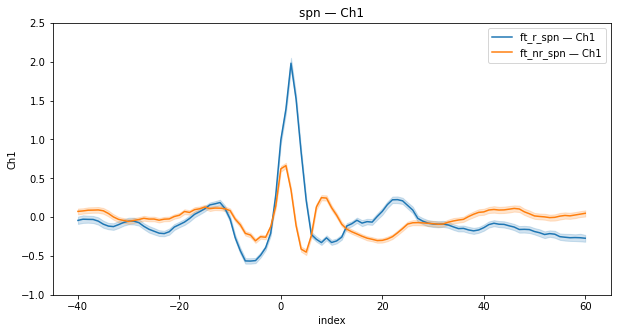

01
02


KeyboardInterrupt: 

<Figure size 720x360 with 0 Axes>

In [21]:
import seaborn as sns
from tqdm.notebook import tqdm

for channel in ['Ch1', 'Ch2', 'Ch5', 'Ch6']:
    plt.figure(figsize=(10,5))
    for alignment_col in ['photometrySideInIndex_r', 'photometrySideInIndex_nr']:
        relative_df = pd.DataFrame()
        
        rel_points = df2[df2[alignment_col] > 0].reset_index()
        identifiers = rel_points[['index', 'nTrial', 'nEndTrial']].dropna().values.astype(int)
        
        lst_extendeds = []
        
        for idx, nTrial, nEndTrial in tqdm(identifiers):
            extended_trial = df2[(df2['nTrial'] == nTrial) | (df2['nEndTrial'] == nEndTrial)].reset_index().copy()
            extended_trial['index'] -= idx

            lst_extendeds.append(extended_trial.copy())
            
        relative_df = pd.concat(lst_extendeds)

        
        alignment_name = alignment_col.split('_')[-1]
        sns.lineplot(x='index', y=channel, data=relative_df[relative_df['index'].between(-40, 60)], label=f'{alignment_col} — {channel}')
        
        plt.title(f'{alignment_name} — {channel}')
        plt.ylim(-1,2.5)
        plt.grid()
        
    plt.legend()
    plt.show()

display(relative_df)


In [ ]:
print(plot_df)